# Modelos Tradicionais (Baseline)

In [1]:
# Importar bibliotecas necessárias
# pip install pmdarima scikit-learn matplotlib pandas
import pandas as pd
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

In [2]:
# Abrir o ficheiro com ; como separador
df = pd.read_csv('datasets/consumo_eredes_limpo1.csv', sep=',')

# 📆 Aplicar ARIMA a uma série apenas os últimos 30 dias para o codigo postal 2840 (Seixal)

In [3]:
# Filtrar apenas os dados do código postal 2840
df_2840 = df[df['Zip Code'] == '2840'].copy()

# Converter a coluna 'Datetime' para datetime (caso ainda não esteja)
df_2840['Datetime'] = pd.to_datetime(df_2840['Datetime'])

# Criar a série temporal horária
serie_horaria_2840 = df_2840.set_index('Datetime')['Energy_Normalized']

# Filtrar apenas os últimos 30 dias
serie_ultimos_30_dias = serie_horaria_2840.last('30D')

# Confirmar quantos registos tem
print(serie_ultimos_30_dias.count())

720


# ⚙️ Aplicar ARIMA

In [4]:
modelo_arima = auto_arima(
    serie_ultimos_30_dias,
    seasonal=True,     # Podes tentar com m=24 (1 dia de ciclo) ou m=168 (1 semana)
    m=24,  # 24 horas
    stepwise=True,
    error_action='ignore',
    suppress_warnings=True,
    trace=True
)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[24] intercept   : AIC=-889.008, Time=4.04 sec
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=38.236, Time=0.08 sec
 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=-886.313, Time=1.57 sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=-580.170, Time=0.59 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=1482.224, Time=0.03 sec
 ARIMA(2,0,2)(0,0,1)[24] intercept   : AIC=inf, Time=3.59 sec
 ARIMA(2,0,2)(1,0,0)[24] intercept   : AIC=-893.984, Time=3.55 sec
 ARIMA(2,0,2)(0,0,0)[24] intercept   : AIC=inf, Time=0.66 sec
 ARIMA(2,0,2)(2,0,0)[24] intercept   : AIC=-900.155, Time=14.19 sec
 ARIMA(2,0,2)(2,0,1)[24] intercept   : AIC=inf, Time=13.59 sec
 ARIMA(1,0,2)(2,0,0)[24] intercept   : AIC=-900.167, Time=9.61 sec
 ARIMA(1,0,2)(1,0,0)[24] intercept   : AIC=-893.707, Time=2.21 sec
 ARIMA(1,0,2)(2,0,1)[24] intercept   : AIC=inf, Time=12.48 sec
 ARIMA(1,0,2)(1,0,1)[24] intercept   : AIC=inf, Time=3.62 sec
 ARIMA(0,0,2)(2,0,0)[24] intercept   : AIC=

In [5]:
# Previsão para as próximas 24 horas
n_periods = 24
previsoes = modelo_arima.predict(n_periods=n_periods)

# Criar datas futuras para previsões (a partir do último ponto da série usada no modelo)
datas_futuras = pd.date_range(start=serie_ultimos_30_dias.index[-1] + pd.Timedelta(hours=1), periods=n_periods, freq='H')

# Criar DataFrame com previsões
df_previsao = pd.DataFrame({'Data': datas_futuras, 'Previsao': previsoes})

# Adicionar intervalo de confiança
previsoes, conf_int = modelo_arima.predict(n_periods=24, return_conf_int=True)

# 📊 Visualizar resultados

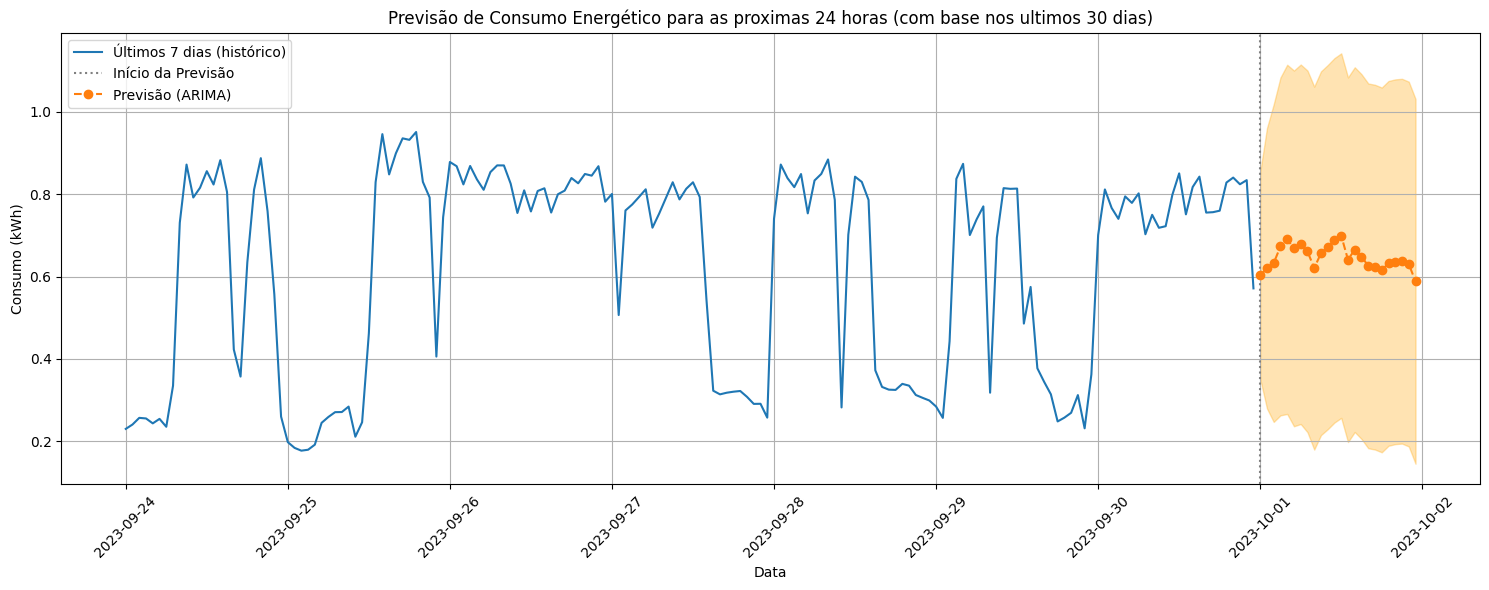

In [6]:
plt.figure(figsize=(15, 6))
plt.plot(serie_ultimos_30_dias[-168:], label='Últimos 7 dias (histórico)')
plt.axvline(x=df_previsao['Data'].iloc[0], color='gray', linestyle=':', label='Início da Previsão')
plt.fill_between(datas_futuras, conf_int[:, 0], conf_int[:, 1], color='orange', alpha=0.3)
plt.plot(df_previsao['Data'], df_previsao['Previsao'], label='Previsão (ARIMA)', linestyle='--', marker='o')
plt.title('Previsão de Consumo Energético para as proximas 24 horas (com base nos ultimos 30 dias)')
plt.xlabel('Data')
plt.ylabel('Consumo (kWh)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 📏 Avaliar o modelo com metricas

In [7]:
real = serie_ultimos_30_dias[-24:].values # comparar as 24 últimas horas reais

# Só executa esta comparação se tens as 24 horas reais disponíveis!
if len(real) == len(previsoes):
    mae = mean_absolute_error(real, previsoes)
    rmse = mean_squared_error(real, previsoes, squared=False)
    print(f"MAE: {mae:.4f} | RMSE: {rmse:.4f}")
else:
    print("⚠️ Não há dados reais suficientes para comparar com as previsões.")

print(modelo_arima.summary())
df_previsao.to_csv('predicts/arima_cp2840.csv', index=False)

MAE: 0.1268 | RMSE: 0.1372
                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  720
Model:             SARIMAX(2, 0, 0)x(2, 0, 0, 24)   Log Likelihood                 457.053
Date:                            Tue, 08 Apr 2025   AIC                           -902.106
Time:                                    16:25:58   BIC                           -874.631
Sample:                                09-01-2023   HQIC                          -891.499
                                     - 09-30-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0844      0.016      5.310      0.000       0.053       0.116
ar.L1   